# Polars Lazy API

So far we have performed **polars** data manipulation using *eager evaluation*.  This means that queries are performed as soon as the code is run.  In this tutorial we explore the *lazy API*.

With the lazy API, **polars** doesn't run each query line-by-line but instead processes the full query end-to-end. To get the most out of **polars** important that you use the lazy API because:

- the lazy API allows **polars** to apply automatic query optimization with the query optimizer
- the lazy API allows you to work with larger than memory datasets using streaming
- the lazy API can catch schema errors before processing the data

## Importing Packages

Let's begin by importing packages.

In [ ]:
import polars as pl

## Using the Lazy API from a File

In the ideal case we would use the lazy API right from a file as the query optimizer may help us to reduce the amount of data we read from the file.

Below we create a lazy query that reads from our options data CSVs.  In particular we grab all out-of-the money options that are worth at least $0.05.

By starting the query with `pl.scan_csv()` we are using the lazy API.

In [ ]:
q1 = (
    pl.scan_csv("data/L3_2018_01/L3_options_*.csv")
    .filter(
        (pl.col("Type") == "call") & (pl.col("Strike") >= pl.col("UnderlyingPrice")) | (pl.col("Type") == "put") & (pl.col("Strike") < pl.col("UnderlyingPrice")),
        (pl.col("Bid") + pl.col("Ask") / 2) > 0.05,
    )
)
q1

At this point, no data has been queried or manipulated.  Rather `q1` is a `LazyFrame` object.

In [ ]:
type(q1)

polars.lazyframe.frame.LazyFrame

The schema of a **polars** `DataFrame` or `LazyFrame` sets out the names of the columns and their datatypes. You can see the schema with the `.collect_schema()` method on a `DataFrame` or `LazyFrame`.

In [ ]:
q1.collect_schema()

Schema([('UnderlyingSymbol', String),
        ('UnderlyingPrice', Float64),
        ('Flags', String),
        ('OptionSymbol', String),
        ('Type', String),
        ('Expiration', String),
        (' DataDate', String),
        ('Strike', Float64),
        ('Last', Float64),
        ('Bid', Float64),
        ('Ask', Float64),
        ('Volume', Int64),
        ('OpenInterest', Int64),
        ('T1OpenInterest', Int64),
        ('IVMean', Float64),
        ('IVBid', Float64),
        ('IVAsk', Float64),
        ('Delta', Float64),
        ('Gamma', Float64),
        ('Theta', Float64),
        ('Vega', Float64),
        ('AKA', String)])

## Query Plan

For any lazy query **polars** has both:

- a non-optimized plan with the set of steps code as we provided it and
- an optimized plan with changes made by the query optimizer

We can understand both the non-optimized and optimized query plans with visualization and by printing them as text.

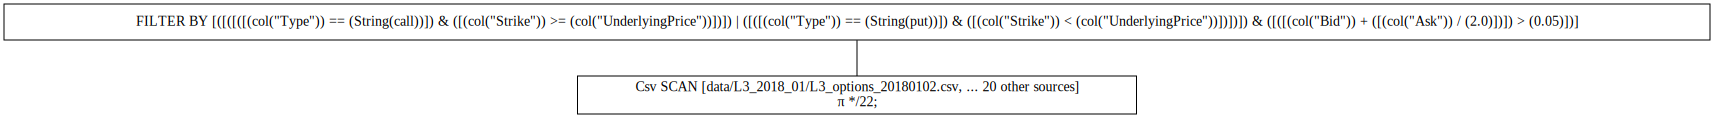

In [ ]:
q1.show_graph(optimized=False)

The query plan visualization should be read from bottom to top. In the visualization:

- each box corresponds to a stage in the query plan
- the $\sigma$ stands for SELECTION and indicates any filter conditions
- the $\pi$ stands for PROJECTION and indicates choosing a subset of columns

Now we visualize the optimized plan with `.show_graph(optimized=True)`.  In this case the query optimizer has identified that the filter can be applied while the CSV is read from disk rather than reading the whole file into memory and then applying the filter. This optimization is called Predicate Pushdown.

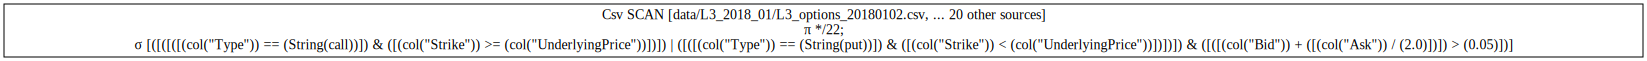

In [ ]:
q1.show_graph(optimized=True)

## Running the Query with `.collect()`

We can run a query with the `LazyFrame.collect()` method.  I'm running the query in a function so that I can time it.  Notice that the query runs slightly faster than reading in the entire data set.

In [ ]:
def test():
    return q1.collect()

%time test()

CPU times: user 27.1 s, sys: 1.78 s, total: 28.8 s
Wall time: 3.73 s


UnderlyingSymbol,UnderlyingPrice,Flags,OptionSymbol,Type,Expiration,DataDate,Strike,Last,Bid,Ask,Volume,OpenInterest,T1OpenInterest,IVMean,IVBid,IVAsk,Delta,Gamma,Theta,Vega,AKA
str,f64,str,str,str,str,str,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,str
"""A""",67.6,"""*""","""A180119P00062500""","""put""","""01/19/2018""","""01/02/2018""",62.5,0.08,0.06,0.1,10,306,306,0.2364,0.2237,0.2492,-0.0539,0.0324,-4.0764,1.566,"""A180119P00062500"""
"""A""",67.6,"""*""","""A180119P00065000""","""put""","""01/19/2018""","""01/02/2018""",65.0,0.27,0.21,0.26,101,21465,21446,0.1929,0.1857,0.2001,-0.1588,0.0878,-7.2872,3.4629,"""A180119P00065000"""
"""A""",67.6,"""*""","""A180119P00067500""","""put""","""01/19/2018""","""01/02/2018""",67.5,0.99,0.82,0.92,1,593,592,0.1654,0.1566,0.1742,-0.468,0.1681,-9.9859,5.6865,"""A180119P00067500"""
"""A""",67.6,"""*""","""A180119C00070000""","""call""","""01/19/2018""","""01/02/2018""",70.0,0.19,0.15,0.22,9,968,977,0.1582,0.1481,0.1683,0.1576,0.1065,-6.2591,3.4456,"""A180119C00070000"""
"""A""",67.6,"""*""","""A180216P00052500""","""put""","""02/16/2018""","""01/02/2018""",52.5,0.09,0.04,0.12,0,371,371,0.3733,0.3404,0.4061,-0.0215,0.0059,-1.8411,1.2141,"""A180216P00052500"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ZYNE""",12.09,"""*""","""ZYNE200117C00015000""","""call""","""01/17/2020""","""01/31/2018""",15.0,4.89,1.8,5.5,0,4,4,0.7,0.4073,0.9927,0.6002,0.0319,-1.127,6.3879,"""ZYNE200117C00015000"""
"""ZYNE""",12.09,"""*""","""ZYNE200117C00017500""","""call""","""01/17/2020""","""01/31/2018""",17.5,0.0,1.15,5.0,0,0,0,0.686,0.3878,0.9842,0.5331,0.0336,-1.1467,6.6061,"""ZYNE200117C00017500"""
"""ZYNE""",12.09,"""*""","""ZYNE200117C00020000""","""call""","""01/17/2020""","""01/31/2018""",20.0,2.1,0.85,4.6,0,12,12,0.6898,0.3975,0.9821,0.4807,0.0336,-1.1613,6.64,"""ZYNE200117C00020000"""
